In [95]:
%load_ext autoreload
%autoreload 2
    
import os
    
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
from torch import LongTensor
from IPython.display import clear_output
from sklearn.datasets import make_swiss_roll
from sklearn.utils import shuffle
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

warnings.filterwarnings("ignore", category=DeprecationWarning) 
    
from pfgmpp.core import PFGMPP
from pfgmpp.training.losses import TargetPredictionLoss
from pfgmpp.training.trainer import PFGMPPTrainer
from pfgmpp.training.networks import TimeConditionedMLP
from pfgmpp.utils.data import InfiniteDataLoader
from pfgmpp.classifier_training.trainer import ClassifierTrainer
from pfgmpp.classifier_training.loss import ClassifierLoss
from ibmd.core import IBMD
from ibmd.training.training_loop import training_loop_instantiated, training_loop

from constants import ARTIFACTS_DIR

DS_NAME = "swiss"
RUN_DIR = os.path.join(ARTIFACTS_DIR, "notebooks_outputs", "toy", DS_NAME)
UNCONDITIONAL_DIR = os.path.join(RUN_DIR, "unconditional")
CONDITIONAL_DIR = os.path.join(RUN_DIR, "conditional")
CLASSIFIER_DIR = os.path.join(RUN_DIR, "classifier")
IBMD_DIR = os.path.join(RUN_DIR, "ibmd")

os.makedirs(UNCONDITIONAL_DIR, exist_ok=True)
os.makedirs(CONDITIONAL_DIR, exist_ok=True)
os.makedirs(CLASSIFIER_DIR, exist_ok=True)
os.makedirs(IBMD_DIR, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

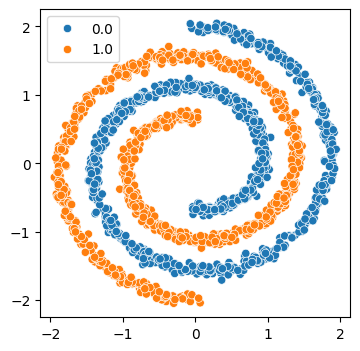

In [96]:
if DS_NAME == "swiss":
    def make_swiss_dataset(num_samples):
        X0, _ = make_swiss_roll(num_samples // 2, noise=0.3, random_state=0)
        X1, _ = make_swiss_roll(num_samples // 2, noise=0.3, random_state=0)
        X0 = X0[:, [0, 2]]
        X1 = X1[:, [0, 2]]
        X1 = -X1
        X, y = shuffle(
            np.concatenate([X0, X1], axis=0),
            np.concatenate([np.zeros(len(X0)), np.ones(len(X1))], axis=0),
            random_state=0)
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    
        return X.astype(np.float32), y

    X, Y = make_swiss_dataset(2000)
elif DS_NAME == "gaussians":
    factor, sigma = 0.5, 0.3
    mu1, sigma1 = factor * np.array([-1, -1]), sigma
    mu2, sigma2 = factor * np.array([1, 1]), sigma
    ds_size = 10_000
    
    X1 = np.random.randn(ds_size//2, len(mu1)) * sigma1 + mu1
    Y1 = np.ones(len(X1)) * 0.
    X2 = np.random.randn(ds_size//2, len(mu2)) * sigma2 + mu2
    Y2 = np.ones(len(X2)) * 1.
    
    X = np.concatenate([X1, X2]).astype(np.float32)
    Y = np.concatenate([Y1, Y2])

MEAN, STD = np.mean(X, axis=0), np.std(X, axis=0)

plt.figure(figsize=(4, 4))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=Y)
plt.show()

## Construct Loader

In [97]:
class LabeledDataset(Dataset):
    def __init__(self, X, Y):
        self.X = (X - MEAN[None]) / STD[None]
        self.Y = Y.astype(np.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [98]:
BATCH_SIZE = 256
train_loader = InfiniteDataLoader(DataLoader(
    LabeledDataset(X=X, Y=Y),
    batch_size=BATCH_SIZE,
    shuffle=True,
))

## Utils

In [107]:
# Poblem Params
DATA_DIM = 2
SIGMA_MIN = 0.002
SIGMA_MAX = 50.0
POWER = 20

# Loss Params
SIGMA_PRIOR_MODE = "log_normal"
SIGMA_DATA = 0.5

# Net Params
HIDDEN_DIM = 64
N_LAYERS = 3
LR = 1e-4

# Sample Params
N_GENS = 10_000
N_CLASSES = 2
LABELS = torch.concatenate([
    torch.zeros(N_GENS//2), torch.ones(N_GENS//2),
]).to(torch.long)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [108]:
def generate(
    *,
    pfgmpp: PFGMPP,
    net: nn.Module,
    sample_size: int,
    num_steps: int=32,
    label: LongTensor=None,
    seed: int=0,
):
    def drift(*, x, t, label):
        return (x - net(x=x, t=t, label=label)) / t
    return pfgmpp.sample(
        drift=drift,
        sample_size=sample_size,
        num_steps=num_steps,
        label=label,
        device=DEVICE,
        seed=seed,
    ).cpu().numpy() * STD[None] + MEAN[None]

def generate_with_classifier(
    *,
    pfgmpp: PFGMPP,
    net: nn.Module,
    classifier: nn.Module,
    sample_size: int,
    label: LongTensor,
    guidance_scale: float=1.,
    num_steps: int=32,
    seed: int=0,
):
    def drift(*, x, t, label):
        return (x - net(x=x, t=t, label=label)) / t
    return pfgmpp.sample_with_classifier(
        drift=drift,
        classifier=classifier,
        guidance_scale=guidance_scale,
        sample_size=sample_size,
        num_steps=num_steps,
        label=label,
        device=DEVICE,
        seed=seed,
    ).cpu().numpy() * STD[None] + MEAN[None]


def generate_with_cfg(
    *,
    pfgmpp: PFGMPP,
    net: nn.Module,
    net_cond: nn.Module,
    sample_size: int,
    label: LongTensor,
    guidance_scale: float=1.,
    num_steps: int=32,
    seed: int=0,
):
    def drift(*, x, t, label):
        return (x - net(x=x, t=t, label=label)) / t
    def drift_cond(*, x, t, label):
        return (x - net_cond(x=x, t=t, label=label)) / t
    return pfgmpp.sample_with_cfg(
        drift=drift,
        drift_cond=drift_cond,
        guidance_scale=guidance_scale,
        sample_size=sample_size,
        num_steps=num_steps,
        label=label,
        device=DEVICE,
        seed=seed,
    ).cpu().numpy() * STD[None] + MEAN[None]

## Unconditional

In [109]:
net = TimeConditionedMLP(dim=DATA_DIM, hidden_dim=HIDDEN_DIM, n_layers=N_LAYERS, out_dim=DATA_DIM).to(DEVICE)
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
pfgmpp = PFGMPP(
    data_dim=DATA_DIM,
    sigma_min=SIGMA_MIN,
    sigma_max=SIGMA_MAX,
    D=2**POWER,
)
loss_fn = TargetPredictionLoss(pfgmpp=pfgmpp, sigma_prior_mode=SIGMA_PRIOR_MODE)
pfgmpp_trainer = PFGMPPTrainer(
    pfgmpp=pfgmpp,
    net=net,
    optimizer=optimizer,
    loss_fn=loss_fn,
)

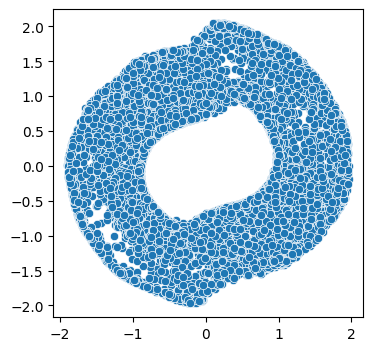

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 487.99it/s, loss=0.66]


In [110]:
n_epochs = 100
sample_every = 10_000

for _ in range(n_epochs):
    clear_output()
    gens =  generate(pfgmpp=pfgmpp, net=net, sample_size=N_GENS)
    plt.figure(figsize=(4, 4))
    sns.scatterplot(x=gens[:, 0], y=gens[:, 1])
    plt.xlabel(""); plt.ylabel("")
    plt.show()

    pfgmpp_trainer.train(
        train_loader=train_loader,
        n_iters=sample_every,
        log_every=5_000,
        save_path=os.path.join(UNCONDITIONAL_DIR, f"{int(POWER)}.pt"),
    )

## Class-conditional

In [111]:
net = TimeConditionedMLP(dim=DATA_DIM, hidden_dim=HIDDEN_DIM, n_layers=N_LAYERS, out_dim=DATA_DIM, n_classes=N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
pfgmpp = PFGMPP(
    data_dim=DATA_DIM,
    sigma_min=SIGMA_MIN,
    sigma_max=SIGMA_MAX,
    D=2**POWER,
)
loss_fn = TargetPredictionLoss(pfgmpp=pfgmpp, sigma_prior_mode=SIGMA_PRIOR_MODE)
pfgmpp_trainer = PFGMPPTrainer(
    pfgmpp=pfgmpp,
    net=net,
    optimizer=optimizer,
    loss_fn=loss_fn,
)

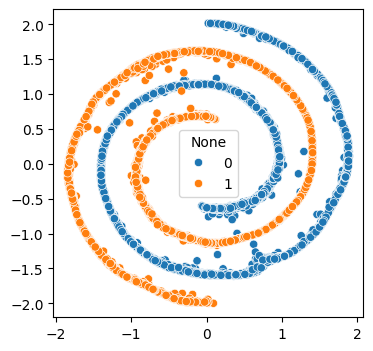

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 6620/10000 [00:15<00:07, 434.69it/s, loss=0.625]

In [ ]:
n_epochs = 100
sample_every = 10_000

for _ in range(n_epochs):
    clear_output()
    gens =  generate(pfgmpp=pfgmpp, net=net, sample_size=N_GENS, label=LABELS.to(DEVICE))
    plt.figure(figsize=(4, 4))
    sns.scatterplot(x=gens[:, 0], y=gens[:, 1], hue=LABELS)
    plt.xlabel(""); plt.ylabel("")
    plt.show()

    pfgmpp_trainer.train(
        train_loader=train_loader,
        n_iters=sample_every,
        log_every=5_000,
        save_path=os.path.join(CONDITIONAL_DIR, f"{int(POWER)}.pt"),
    )

## Classifier Guided

### Classifier Training

In [ ]:
cls = TimeConditionedMLP(dim=DATA_DIM, hidden_dim=HIDDEN_DIM, n_layers=N_LAYERS, out_dim=2).to(DEVICE)
cls_optimizer = torch.optim.Adam(cls.parameters(), lr=LR)
pfgmpp = PFGMPP(
    data_dim=DATA_DIM,
    sigma_min=SIGMA_MIN,
    sigma_max=SIGMA_MAX,
    D=2**POWER,
)
cls_loss_fn = ClassifierLoss(pfgmpp=pfgmpp)
cls_trainer = ClassifierTrainer(
    pfgmpp=pfgmpp,
    net=cls,
    optimizer=cls_optimizer,
    loss_fn=cls_loss_fn,
)

In [ ]:
cls_trainer.train(
    train_loader=train_loader,
    n_iters=500_000,
    log_every=5_000,
    save_path=os.path.join(CLASSIFIER_DIR, f"{int(POWER)}.pt"),
)

### Sampling

In [ ]:
pfgmpp = PFGMPP(
    data_dim=DATA_DIM,
    sigma_min=SIGMA_MIN,
    sigma_max=SIGMA_MAX,
    D=2**POWER,
)

pfgmpp_uncond = TimeConditionedMLP(dim=DATA_DIM, hidden_dim=HIDDEN_DIM, n_layers=N_LAYERS, out_dim=DATA_DIM).to(DEVICE)
pfgmpp_cond = TimeConditionedMLP(dim=DATA_DIM, hidden_dim=HIDDEN_DIM, n_layers=N_LAYERS, out_dim=DATA_DIM, n_classes=N_CLASSES).to(DEVICE)
cls = TimeConditionedMLP(dim=DATA_DIM, hidden_dim=HIDDEN_DIM, n_layers=N_LAYERS, out_dim=2).to(DEVICE)

pfgmpp_uncond.load_state_dict(torch.load(os.path.join(UNCONDITIONAL_DIR, f"{int(POWER)}.pt")))
pfgmpp_cond.load_state_dict(torch.load(os.path.join(CONDITIONAL_DIR, f"{int(POWER)}.pt")))
cls.load_state_dict(torch.load(os.path.join(CLASSIFIER_DIR, f"{int(POWER)}.pt")));

In [ ]:
# check unconditional
gens = generate(pfgmpp=pfgmpp, net=pfgmpp_uncond, sample_size=N_GENS)
plt.figure(figsize=(4, 4))
sns.scatterplot(x=gens[:, 0], y=gens[:, 1])
plt.xlabel(""); plt.ylabel("")
plt.show()

In [ ]:
# check conditional
gens =  generate(pfgmpp=pfgmpp, net=pfgmpp_cond, sample_size=N_GENS, label=LABELS.to(DEVICE))
plt.figure(figsize=(4, 4))
sns.scatterplot(x=gens[:, 0], y=gens[:, 1], hue=LABELS)
plt.xlabel(""); plt.ylabel("")
plt.show()

In [ ]:
# with guidance
gens =  generate_with_classifier(
    pfgmpp=pfgmpp,
    net=pfgmpp_uncond,
    classifier=cls,
    guidance_scale=1.,
    sample_size=N_GENS,
    label=LABELS.to(DEVICE)
)
plt.figure(figsize=(4, 4))
sns.scatterplot(x=gens[:, 0], y=gens[:, 1], hue=LABELS)
plt.xlabel(""); plt.ylabel("")
plt.show()

In [ ]:
# with cfg
gens =  generate_with_cfg(
    pfgmpp=pfgmpp,
    net=pfgmpp_uncond,
    net_cond=pfgmpp_cond,
    guidance_scale=3,
    sample_size=N_GENS,
    label=LABELS.to(DEVICE)
)
plt.figure(figsize=(4, 4))
sns.scatterplot(x=gens[:, 0], y=gens[:, 1], hue=LABELS)
plt.xlabel(""); plt.ylabel("")
plt.show()

In [ ]:
scales = [0.] + [float(2**p) for p in [-1, 0, 1., 2, 3]]
nplots = len(scales)
ncols, nrows = 3, nplots//3
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows))

for idx, scale in enumerate(scales):
    row = idx // ncols
    col = idx % ncols
    ax = axes[row, col]
    
    gens =  generate_with_classifier(
        pfgmpp=pfgmpp,
        net=pfgmpp_uncond,
        classifier=cls,
        guidance_scale=scale,
        sample_size=N_GENS,
        label=LABELS.to(DEVICE),
    )
    
    sns.scatterplot(x=gens[:, 0], y=gens[:, 1], hue=LABELS, ax=ax)
    ax.set_xlabel(""); ax.set_ylabel("")
    ax.set_title(f"{np.round(scale, 1)}")

# IBMD

## Teacher init

In [ ]:
pfgmpp = PFGMPP(
    data_dim=DATA_DIM,
    sigma_min=SIGMA_MIN,
    sigma_max=SIGMA_MAX,
    D=2**POWER,
)
pfgmpp_cond = TimeConditionedMLP(dim=DATA_DIM, hidden_dim=HIDDEN_DIM, n_layers=N_LAYERS, out_dim=DATA_DIM, n_classes=N_CLASSES).to(DEVICE)
pfgmpp_cond.load_state_dict(torch.load(os.path.join(CONDITIONAL_DIR, f"{int(POWER)}.pt")));

In [ ]:
# check conditional
gens = generate(pfgmpp=pfgmpp, net=pfgmpp_cond, sample_size=N_GENS, label=LABELS.to(DEVICE))
plt.figure(figsize=(4, 4))
sns.scatterplot(x=gens[:, 0], y=gens[:, 1], hue=LABELS)
plt.xlabel(""); plt.ylabel("")
plt.show()

## IBMD init

In [ ]:
BATCH_SIZE = 512
INNER_PROBLEM_ITERS = 5

In [ ]:
ibmd = IBMD(
    teacher_dynamics=pfgmpp,
    teacher_net=pfgmpp_cond,
    teacher_loss_fn=TargetPredictionLoss(pfgmpp=pfgmpp),
    student_net_optimizer_config={"lr": 5e-5},
    student_data_estimator_net_config={"lr": 5e-5},
    n_classes=N_CLASSES,
    ema_decay=0.99,
)

In [ ]:
def callback(ibmd: IBMD, it: int):
    clear_output()
    gens = ibmd.sample(sample_size=N_GENS, label=LABELS.to(DEVICE)).cpu().numpy()
    plt.figure(figsize=(4, 4))
    sns.scatterplot(x=gens[:, 0], y=gens[:, 1], hue=LABELS)
    plt.xlabel(""); plt.ylabel("")
    plt.show()

In [ ]:
callback(ibmd, it=0)

In [ ]:
sample_every = 500
n_epochs = 100

it = 0
for _ in range(n_epochs):
    callback(ibmd, it=it)
    for _ in tqdm(range(sample_every)):
        ibmd.train_step(batch_size=BATCH_SIZE, inner_problem_iters=INNER_PROBLEM_ITERS)
        it += 1
callback(ibmd, it=it)